In [59]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
#from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error
from modelling_functions import *

## Processing for Models

In [108]:
#### Read Data files
dict_dictonary = {}
housing, housing_features, feat_labels, dict_dictonary = read_and_clean(filepath = "../data/train_selected_features.csv")

/home/sama/Bootcamp/Project/machina_ex_kaggle/modelling/modelling_functions.py:110: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.col, id_dictonary = to_numeric(housing, col, 'SalePrice')


In [109]:
htest_id, htest_features, htest_labels, htest_dictonary = read_and_clean(filepath = "../data/test_selected_features.csv", test = True, dictonary = dict_dictonary)

/home/sama/Bootcamp/Project/machina_ex_kaggle/modelling/modelling_functions.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.col, id_dictonary = to_numeric_test(housing, col, dictonary)


In [110]:
training = housing_features
testing = htest_features

In [111]:
print(training.shape)
print(testing.shape)

(1455, 66)
(1459, 66)


In [11]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.33, random_state = 0)

## RandomForestRegressor

In [36]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 1288, 2377, 3466, 4555, 5644, 6733, 7822, 8911, 10000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 29, 48, 67, 86, 105, 124, 143, 162, 181, 200, None], 'min_samples_split': [2, 5, 10, 15, 20, 30, 40], 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64], 'bootstrap': [True, False]}


In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(htrain, ptrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/sama/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [9]:
rf_random.best_params_

{'n_estimators': 4555,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 162,
 'bootstrap': False}

In [17]:
clf = RandomForestRegressor(n_estimators=4555, 
                            random_state=9, 
                            n_jobs=-1, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'sqrt', 
                            max_depth = 162,
                            bootstrap = False)
#sfm = SelectFromModel(clf, threshold = 0.01)
#sfm.fit(htrain, ptrain)
# ## Not Finished
# # Measure Feature Importance
#feature_selected = []
#for feature_list_index in sfm.get_support(indices=True):
#     feature_selected.append(feat_labels[feature_list_index])
#proxy = feature_selected
#trimmed = ['x1stflrsf', 'x2ndflrsf', 'garagecars', 'overallcond', 'saleprice', 'Unnamed: 0', 'bsmtfinsf1']
#testing = testing[proxy]
#housing_features = housing_features[trimmed_features]
#print(feature_selected)

In [34]:
clf.fit(htrain, ptrain)

clf.score(htest, ptest)

NameError: name 'clf' is not defined

In [19]:
nice = clf.predict(htest)
mean_squared_error(nice, ptest)

0.022411580487852308

In [140]:
pred = np.exp(clf.predict(htest_features))
Submission(htest_id, pred)

## ElasticNet

In [164]:
regr = ElasticNetCV(alphas = [90e-6], 
                    l1_ratio = 1, 
                    cv = 5, 
                    n_jobs = -1,
                    n_alphas = 1,
                    normalize = True,
                    verbose = 0)

In [161]:
regr.fit(htrain, ptrain)

ElasticNetCV(alphas=[9e-05], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=1, n_jobs=-1, normalize=True,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

ValueError: Invalid parameter alpha_ for estimator ElasticNetCV(alphas=array([1.00000e-09, 1.01109e-06, ..., 9.89899e-05, 1.00000e-04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.9,
       max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [162]:
regr.score(htest, ptest)
pred = regr.predict(htest)
mean_squared_error(pred, ptest)

0.014967203805252818

In [163]:
regr.l1_ratio_

0.5

## Lasso

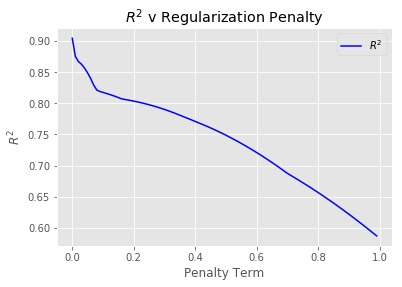

In [25]:
alp = optimize_penalty(htrain, ptrain, model=Lasso, min_=1e-7, max_=1, step=0.0001, plot=True)

In [9]:
alp.best_params_

AttributeError: 'tuple' object has no attribute 'best_params_'

In [116]:
lasso = Lasso(normalize=True)
lasso.set_params(alpha = 90e-6)
lasso.fit(htrain, ptrain)

print(lasso.score(htrain, ptrain))
print(lasso.score(htest, ptest))
#print(selected_coefs)
pred = lasso.predict(htest)
mean_squared_error(pred, ptest)

0.9167323779020945
0.90771667582178


0.014738153686995355

In [117]:
mean_squared_error(pred, ptest)

0.014738153686995355

In [60]:
lasso.coef_

array([-4.00122150e-04,  3.80274314e-02,  8.88175791e-04,  1.33613398e-01,
        7.47400833e-03,  1.07816189e-02,  0.00000000e+00,  1.77257351e-01,
        1.54573275e-02,  0.00000000e+00,  2.19368820e-02,  2.14043249e-02,
        9.70678080e-03,  0.00000000e+00,  5.59837380e-02,  4.85716640e-04,
        0.00000000e+00,  1.00753383e-03,  2.45802635e-02,  1.25573600e-03,
        4.70415252e-03,  0.00000000e+00,  3.48560578e-05,  1.44313198e-02,
        1.17392967e-02,  0.00000000e+00,  8.27475106e-03,  1.73762019e-02,
        2.08383893e-02,  0.00000000e+00, -0.00000000e+00, -1.71739167e-03,
        5.09191218e-03, -3.90531064e-04,  2.65258629e-02,  7.66217088e-02,
        0.00000000e+00, -1.90526093e-05,  2.23112555e-02,  3.89943359e-02,
        2.52019032e-02,  1.33939866e-03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  3.25772137e-02,  0.00000000e+00,  8.97817530e-02,
        2.04338143e-02,  5.96895533e-03,  0.00000000e+00,  0.00000000e+00,
        4.15963757e-03,  

In [118]:
drop_col = list(np.where(lasso.coef_ == 0)[0])

In [119]:
drop_col

[6, 9, 13, 16, 21, 25, 29, 30, 36, 42, 43, 44, 46, 50, 51, 60, 61, 62]

In [63]:
lasso_coefs = list(lasso.coef_[np.where(lasso.coef_ != 0)])

In [64]:
lasso_coefs

[-0.00040012214952619084,
 0.03802743139813506,
 0.0008881757908969451,
 0.13361339762220878,
 0.007474008326081708,
 0.010781618916076147,
 0.17725735137385387,
 0.015457327508832087,
 0.021936881977614446,
 0.021404324883712387,
 0.009706780796411473,
 0.05598373795565064,
 0.0004857166395080413,
 0.0010075338320192683,
 0.024580263518463458,
 0.0012557360012269427,
 0.004704152519978455,
 3.485605778662989e-05,
 0.014431319779286501,
 0.011739296692436877,
 0.00827475105895666,
 0.0173762018986732,
 0.020838389329772077,
 -0.0017173916665672358,
 0.00509191217797073,
 -0.00039053106445182875,
 0.026525862883153548,
 0.07662170882167045,
 -1.905260925657254e-05,
 0.02231125552687231,
 0.0389943358914647,
 0.02520190323070489,
 0.0013393986568090669,
 0.032577213730934924,
 0.08978175301420739,
 0.020433814262265836,
 0.0059689553320660975,
 0.004159637569030186,
 0.019304025483747007,
 0.001300698857968232,
 0.0012147723605755792,
 -4.644409147703174e-05,
 0.00014637141211271747,
 0.

In [32]:
htrain.columns

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 'centralair',
       'electrical', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'x3ssnporch',
       'screenporch', 'poolarea', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition

In [98]:
pred = np.exp(lasso.predict(testing))

In [99]:
pred[1:10]

array([157968.48361597, 172690.34087731, 186551.6437822 , 191678.92217207,
       170905.23289   , 164269.7483112 , 159704.51607108, 190846.95089362,
       118432.5453594 ])

In [100]:
Submission(htest_id, pred)

## Linear Model

In [140]:
lm = LinearRegression(normalize = True, n_jobs = -1)

In [141]:
training = housing_features.drop(housing_features.columns[drop_col], axis=1)
testing = htest_features.drop(housing_features.columns[drop_col], axis=1)

In [142]:
print(training.shape)
print(testing.shape)

(1455, 48)
(1459, 48)


In [143]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.33, random_state = 0)

In [144]:
lm.fit(htrain, ptrain)

lm.score(htest, ptest)

0.9051018423596444

In [100]:
lm.sample_

AttributeError: 'LinearRegression' object has no attribute 'sample_'

In [145]:
pred = lm.predict(htest)
mean_squared_error(pred, ptest)

0.0151557569514424

In [146]:
pred = np.exp(lm.predict(testing))
print(pred[1:3])
Submission(htest_id, pred)

[158204.65351117 173280.29005707]
